In [ ]:
!pip install hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dependencies .. lets put all the dependencies here
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import numpy as np
import datetime as dt
import hvplot.pandas as hv
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

In [ ]:
global data
data = None

def read_csv():
  global data
  if data == None:
    data = pd.read_csv('credit_card_transactions.csv')
  return data.copy()

In [ ]:
df_transactions = read_csv()
df_transactions.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [ ]:
df_merchants = df_transactions[['trans_date_trans_time','cc_num','merchant','category','amt','city','state','zip','city_pop','job','dob','merch_zipcode']]
df_merchants.head()

,trans_date_trans_time,cc_num,merchant,category,amt,city,state,zip,city_pop,job,dob,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,59632,1939,Patent attorney,1967-01-12,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,22844.0


In [ ]:
df_merchants['transaction_datetime'] = pd.to_datetime(df_merchants['trans_date_trans_time'])

<ipython-input-9-9de7cdf01362>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merchants['transaction_datetime'] = pd.to_datetime(df_merchants['trans_date_trans_time'])


In [ ]:
df_merchants.drop(columns=['trans_date_trans_time'], inplace=True)
df_merchants.head()

<ipython-input-10-faaf70fe9115>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merchants.drop(columns=['trans_date_trans_time'], inplace=True)


,cc_num,merchant,category,amt,city,state,zip,city_pop,job,dob,merch_zipcode,transaction_datetime
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,28705.0,2019-01-01 00:00:18
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,NaN,2019-01-01 00:00:44
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,83236.0,2019-01-01 00:00:51
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,59632,1939,Patent attorney,1967-01-12,NaN,2019-01-01 00:01:16
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,22844.0,2019-01-01 00:03:06


In [ ]:
df_merchants['merchant'] = df_merchants['merchant'].apply(lambda x: x.strip('fraud_'))
df_merchants.head()

<ipython-input-11-d0b00aaf0a8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merchants['merchant'] = df_merchants['merchant'].apply(lambda x: x.strip('fraud_'))


,cc_num,merchant,category,amt,city,state,zip,city_pop,job,dob,merch_zipcode,transaction_datetime
0,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,28705.0,2019-01-01 00:00:18
1,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,NaN,2019-01-01 00:00:44
2,38859492057661,Lind-Buckridge,entertainment,220.11,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,83236.0,2019-01-01 00:00:51
3,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,59632,1939,Patent attorney,1967-01-12,NaN,2019-01-01 00:01:16
4,375534208663984,Keeling-Crist,misc_pos,41.96,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,22844.0,2019-01-01 00:03:06


In [ ]:
df_merchant_summary = df_merchants.groupby(['merchant']).agg(total_sales = ('amt','sum')).sort_values(by='total_sales', ascending=False)
df_merchant_summary.head()

,total_sales
merchant,
Kilback LLC,391078.15
Bradtke PLC,302481.25
Doyle Lt,300971.37
Hackett-Lueilwitz,300208.14
"Schumm, Bauch and Ondrick",299115.14


In [ ]:
df_merchant_top10 = df_merchant_summary.head(10)
plot_merchant_summary_up = df_merchant_top10.hvplot.bar(rot=45, x='merchant', y='total_sales', ylim=(0, 500000), height=500, width=800)
plot_merchant_summary_up.opts(title='TOP 10 Selling Merchants (entire duration)', xlabel='Merchants', ylabel='Total Sales')
plot_merchant_summary_up

:Bars   [merchant]   (total_sales)

In [ ]:
df_merchant_bottom10 = df_merchant_summary.tail(10)
plot_merchant_summary_down = df_merchant_bottom10.hvplot.bar(rot=45, x='merchant', y='total_sales', ylim=(0, 60000), height=500, width=800)
plot_merchant_summary_down.opts(title='10 Least Selling Merchants (entire duration)', xlabel='Merchants', ylabel='Total Sales')
plot_merchant_summary_down

:Bars   [merchant]   (total_sales)

In [ ]:
df_merchants.set_index('transaction_datetime', inplace=True)
df_merchants.head(5)

,cc_num,merchant,category,amt,city,state,zip,city_pop,job,dob,merch_zipcode
transaction_datetime,,,,,,,,,,,
2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,28705.0
2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,NaN
2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,83236.0
2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,59632,1939,Patent attorney,1967-01-12,NaN
2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,22844.0


<Axes: title={'center': 'Top 10 Sale for Merchant Quarter combination'}, xlabel='Year-Quarter-Merchant', ylabel='Total Sale for Quarter/Merchant'>

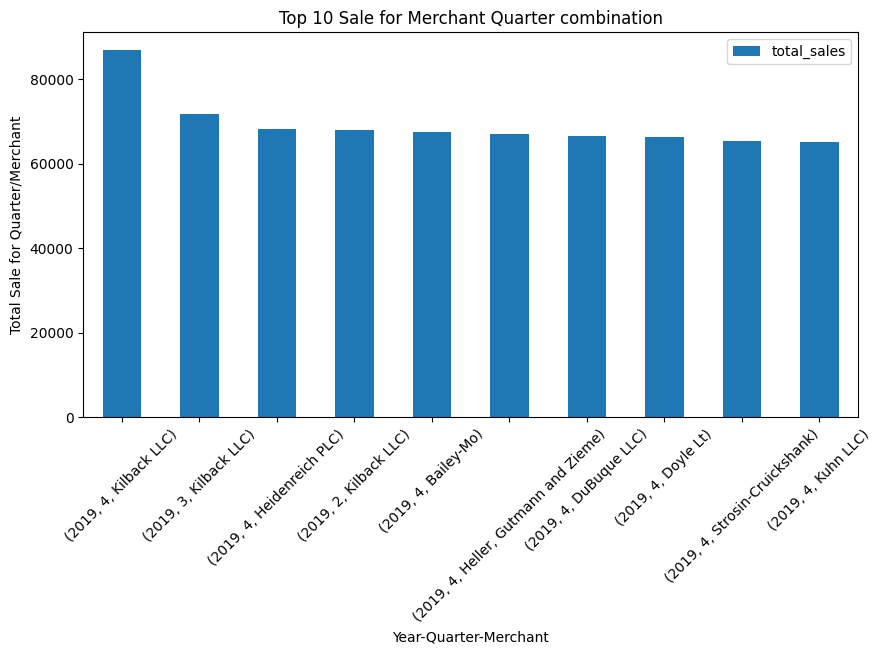

In [ ]:
df_merchant_category_summarized = df_merchants.groupby(by = [df_merchants.index.year, df_merchants.index.quarter, 'merchant']).agg(total_sales = ('amt','sum'))

df_merchant_sales_for_quarter = df_merchant_category_summarized.sort_values(by=['total_sales'], ascending=False)

df_merchant_sales_for_quarter.head(10).plot(kind='bar', rot=45 ,xlabel='Year-Quarter-Merchant', ylabel= 'Total Sale for Quarter/Merchant', title ='Top 10 Sale for Merchant Quarter combination' ,figsize=(10,5))

<Axes: title={'center': '10 Least Sale for Merchant Quarter combination'}, xlabel='Year-Quarter-Merchant', ylabel='Total Sale for Quarter/Merchant'>

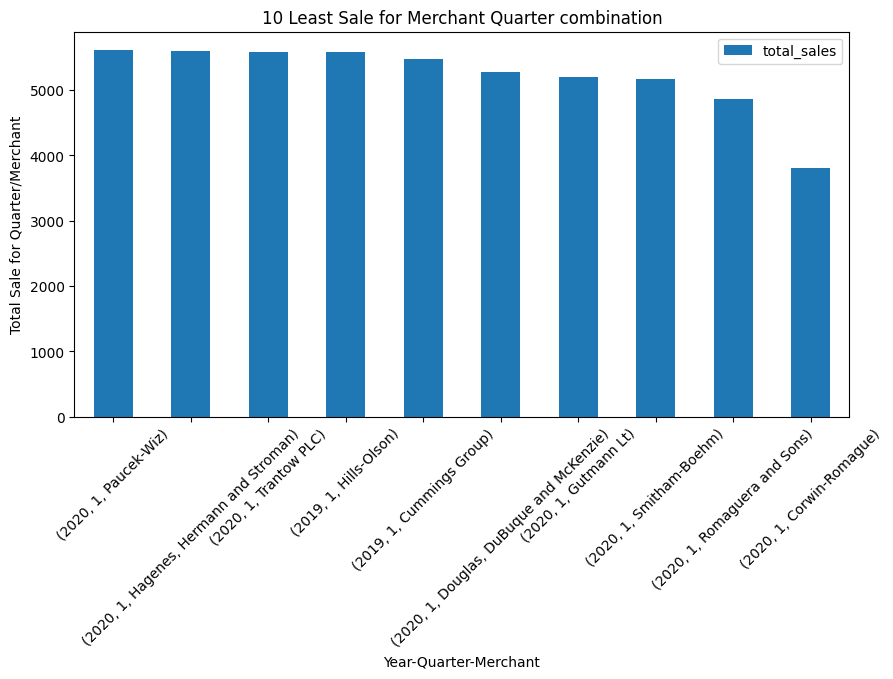

In [ ]:
df_merchant_sales_for_quarter.tail(10).plot(kind='bar', xlabel='Year-Quarter-Merchant', rot=45, ylabel= 'Total Sale for Quarter/Merchant', title ='10 Least Sale for Merchant Quarter combination' ,figsize=(10,5))

In [ ]:
df_sales = df_merchants[['amt']]
df_sales['days_in_months'] = df_sales.index.days_in_month
df_sales['year'] = df_sales.index.year

df_sales_yearwise = df_sales.groupby(by = [df_sales.index.month]).agg(
    total_sales_month = ('amt','sum'),
    count_transactions = ('amt','count'),
    days_in_months = ('days_in_months','mean'),
    avg_sales_month = ('amt','mean'),
    max_year = ('year','max'),
    min_year = ('year','min')
    )

df_sales_yearwise.index.names = ['month']
df_sales_yearwise['avg_sales_per_month'] = df_sales_yearwise['total_sales_month']/((df_sales_yearwise['max_year']-df_sales_yearwise['min_year'])+1)
df_sales_yearwise['avg_transaction_per_month'] = df_sales_yearwise['count_transactions']/((df_sales_yearwise['max_year']-df_sales_yearwise['min_year'])+1)

nos_of_merchants = len(df_merchants['merchant'].unique())

df_sales_yearwise['sales/month/customer'] = df_sales_yearwise['avg_sales_per_month']/nos_of_merchants
df_sales_yearwise['transaction/month/customer'] = df_sales_yearwise['avg_transaction_per_month']/nos_of_merchants

<ipython-input-19-1f470103ffe9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['days_in_months'] = df_sales.index.days_in_month
<ipython-input-19-1f470103ffe9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['year'] = df_sales.index.year


In [ ]:
df_sales_yearwise_copy = df_sales_yearwise[['sales/month/customer','transaction/month/customer']]
df_sales_yearwise_copy

,sales/month/customer,transaction/month/customer
month,,
1,5355.566032,75.560606
2,5032.183463,70.459596
3,7352.094141,103.743867
4,6820.226811,97.380952
5,7435.021746,105.970418
6,7318.457554,103.759740
7,8721.539307,124.958153
8,8726.246248,126.059163
9,7142.618211,101.950938


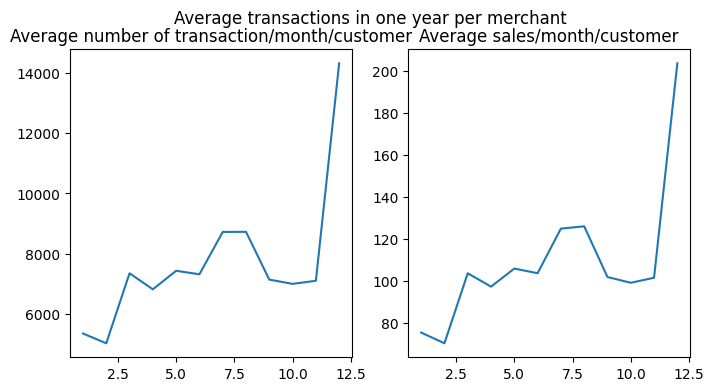

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

fig.suptitle('Average transactions in one year per merchant')
ax1.set_title('Average number of transaction/month/customer')
ax2.set_title('Average sales/month/customer')
ax1.plot(df_sales_yearwise_copy.index, df_sales_yearwise_copy['sales/month/customer'], label='sales/month/customer', )
ax2.plot(df_sales_yearwise_copy.index, df_sales_yearwise_copy['transaction/month/customer'], label='transaction/month/customer')

In [ ]:
df_merchants_bottom = df_merchants.loc[df_merchants['merchant'].isin([x for x in df_merchant_bottom10.index])]
df_merchants_sales_bottom_pvt = pd.pivot_table(df_merchants_bottom, values='amt', index=[df_merchants_bottom.index.month], columns ='merchant', aggfunc='sum')
df_merchants_sales_bottom_pvt.hvplot(kind='line', xlabel='Months', rot=45, ylabel= 'Merchant', title ='10 Least Sale for Merchant over year' ,figsize=(20,10))

:NdOverlay   [merchant]
   :Curve   [transaction_datetime]   (value)

In [ ]:
df_merchants_cnt_trans_bottom_pvt = pd.pivot_table(df_merchants_bottom, values='amt', index=[df_merchants_bottom.index.month], columns ='merchant', aggfunc='count')
df_merchants_cnt_trans_bottom_pvt.hvplot(kind='line', xlabel='Months', rot=45, ylabel= 'Merchant', title ='Nos of transaction for 10 Least Sale for Merchant over year' ,figsize=(25,10))

:NdOverlay   [merchant]
   :Curve   [transaction_datetime]   (value)

In [ ]:
df_merchants_top = df_merchants.loc[df_merchants['merchant'].isin([x for x in df_merchant_top10.index])]
df_merchants_sales_top_pvt = pd.pivot_table(df_merchants_top, values='amt', index=[df_merchants_top.index.month], columns ='merchant', aggfunc='sum')
df_merchants_sales_top_pvt.hvplot(kind='line', xlabel='Months', rot=45, ylabel= 'Merchant', title ='10 Top Selling Merchants over year' ,figsize=(20,10))

:NdOverlay   [merchant]
   :Curve   [transaction_datetime]   (value)

In [ ]:
df_merchants_cnt_trans_top_pvt = pd.pivot_table(df_merchants_top, values='amt', index=[df_merchants_top.index.month], columns ='merchant', aggfunc='count')
df_merchants_cnt_trans_top_pvt.hvplot(kind='line', xlabel='Months', rot=45, ylabel= 'Merchant', title ='Nos of transactions for 10 Top Selling Merchant for year' ,figsize=(25,10))

:NdOverlay   [merchant]
   :Curve   [transaction_datetime]   (value)

In [ ]:
df_merchant_summary['quartile'] = pd.qcut(df_merchant_summary['total_sales'], q=4, labels=False)

In [ ]:
quantile = df_merchant_summary['total_sales'].quantile([0.25,0.5,0.75])

iqr = quantile.loc[0.75] - quantile.loc[0.25]
upperbound = quantile.loc[0.5] + (1.5 * (iqr))
lowerbound = quantile.loc[0.5] - (1.5 * (iqr))

print(f'Merchant wise sale details:')
print(f'Upperbound: {upperbound} Lowerbound: {lowerbound} Median: {quantile.loc[0.5]} IQR: {iqr}')

Merchant wise sale details:
Upperbound: 227576.685 Lowerbound: 7988.474999999991 Median: 117782.58 IQR: 73196.07


In [ ]:
df_quartiles = df_merchant_summary.groupby('quartile').agg(quartitle_sales = ('total_sales','sum'), count_merchants=('quartile','count'))

Calculating 75 %tile sales merchants

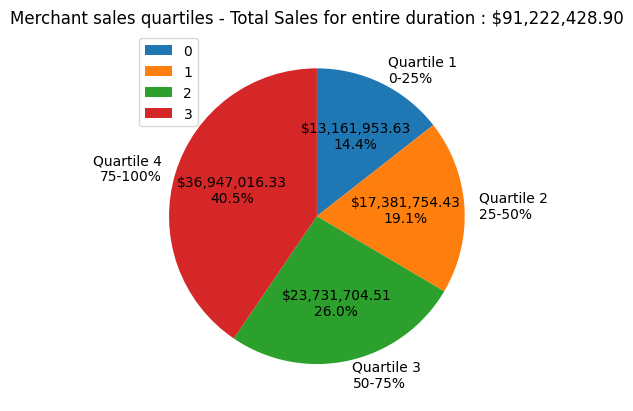

In [ ]:
fig, (ax1) = plt.subplots(1)
_wedges, labels, percentages = ax1.pie(df_quartiles['quartitle_sales'], labels=df_quartiles.index, autopct='%1.1f%%', counterclock=False,
                                       startangle=90)
percentiles = [x*25 for x in range(0, 5, 1)]
i = 0
for label, percentage in zip(labels, percentages):
    label.set_text('Quartile ' + str(i+1) + '\n' + str(percentiles[i]) + '-' + str(percentiles[i+1]) + '%')
    amount = df_quartiles.iloc[i]['quartitle_sales']
    percentage.set_text(f'${amount:,.2f}\n{str(percentage.get_text())}')
    i += 1

total_sales = df_quartiles['quartitle_sales'].sum()
plt.title(f'Merchant sales quartiles - Total Sales for entire duration : ${total_sales:,.2f}')

plt.legend(loc='upper left')

plt.show()

<Axes: title={'center': 'Top 10 Sale for Merchant Quarter State combination'}, xlabel='Year-Quarter-Merchant-State', ylabel='Total Sale for Quarter/Merchant'>

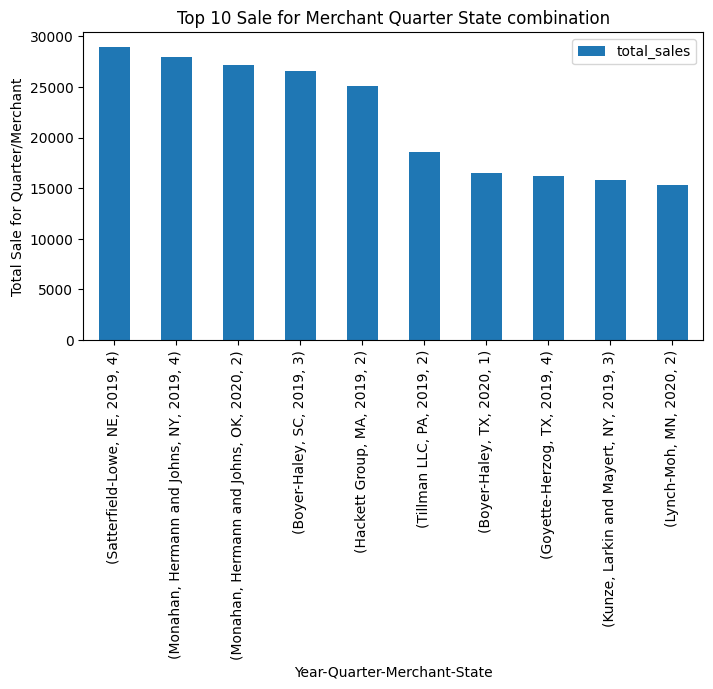

In [ ]:
df_merchant_state = df_merchants[['merchant','category','amt','state']]

df_merchant_state_quarterly = df_merchant_state.groupby(by = ['merchant','state',df_merchant_state.index.year ,df_merchant_state.index.quarter]).agg(total_sales = ('amt','sum'))
df_merchant_state_quarterly.index.names = ['merchant','state','year','quarter']
df_merchant_state_quarterly = df_merchant_state_quarterly.sort_values (by='total_sales', ascending=False)
df_merchant_state_quarterly.head(10).plot(kind='bar', rot=90 ,xlabel='Year-Quarter-Merchant-State', ylabel= 'Total Sale for Quarter/Merchant', title ='Top 10 Sale for Merchant Quarter State combination' ,figsize=(8,4))

<Axes: title={'center': 'Lowest 10 Sale for Merchant Quarter State combination'}, xlabel='Year-Quarter-Merchant-State', ylabel='Total Sale for Quarter/Merchant statewise'>

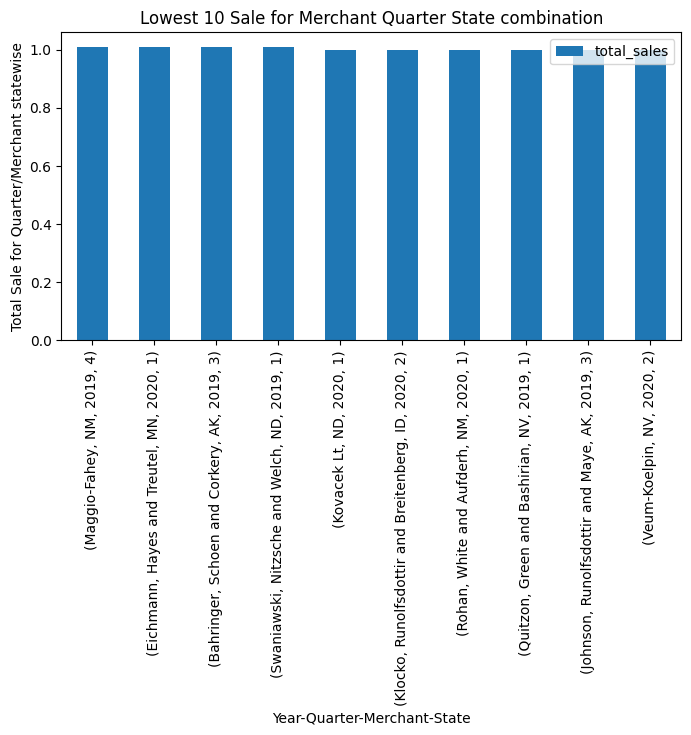

In [ ]:
df_merchant_state_quarterly.tail(10).plot(kind='bar', rot=90 ,xlabel='Year-Quarter-Merchant-State', ylabel= 'Total Sale for Quarter/Merchant statewise', title ='Lowest 10 Sale for Merchant Quarter State combination' ,figsize=(8,4))

In [ ]:
df_merchant_statewise = df_merchant_state.groupby(by = ['merchant','state']).agg(total_sales = ('amt','sum')).sort_values(by='total_sales', ascending=False)
df_merchant_statewise.head(10)

,,total_sales
merchant,state,
"Monahan, Hermann and Johns",NY,34750.53
Kuhn LLC,TX,32383.47
Boyer-Haley,TX,30213.64
Satterfield-Lowe,NE,29739.33
"Monahan, Hermann and Johns",OK,28716.68
Kilback LLC,TX,27607.47
Boyer-Haley,SC,26636.29
Goodwin-Nitzsche,TX,26512.90
"Lockman, West and Runte",TX,26474.23


In [ ]:
df_merchant_statewise_top10 = df_merchant_statewise.head(10)
df_merchant_statewise_top10.index.names = ['merchant','state']
df_merchant_statewise_top10.hvplot(kind='bar', rot=45, x='merchant', by='state', y='total_sales', ylim=(0, 40000), title='TOP 10 Merchant State combination sales' ,height=500, width=1500)

:Bars   [merchant,state]   (total_sales)

In [ ]:
df_merchant_statewise_bottom10 = df_merchant_statewise.tail(10)
df_merchant_statewise_bottom10.index.names = ['merchant','state']
df_merchant_statewise_bottom10.hvplot(kind='bar', rot=45, x='merchant', by='state', y='total_sales', ylim=(0, 2), title='Least 10 Merchant State combination sales',legend='top_right' ,height=500, width=1500)

:Bars   [merchant,state]   (total_sales)